Importing Required Packages and loading saved historical Data

In [ ]:
import pandas as pd
import numpy as np
from google.colab import  drive
drive.mount('/drive')
stock = "MSFT"
filename = "/drive/My Drive/Colab Notebooks/%sDataHist.csv" % stock
stockData = pd.read_csv(filename)
#stockData["CloseChange"] = stockData["Close"].pct_change()
#stockData["VolChange"] = stockData["Volume"].pct_change()
#stockData["PriceChange"] = (stockData["High"] - stockData["Low"])/stockData["Open"]
#if stockData["CloseChange"]
#stockData["Trend"] = np.where(stockData['CloseChange']> 0 , 1, 0)


Mounted at /drive



1.   Defining feature and target variables

2.   Function to Difference Data Series



In [ ]:
#features = ["Close", "CloseChange", "VolChange","PriceChange", "Open", "High", "Low", "Adj Close", "Volume"]
features = ["Adj Close","Close","Open", "High", "Low"]#, "Volume"]
target = ["Adj Close"]

# create a differenced dataset
def differenceData(data, features, interval=1):
  diffData = data.copy()
  for var in features :
    diff = [np.nan]
    for i in range(interval, len(data)):
      value = diffData[var][i] - diffData[var][i - interval]
      diff.append(value)
    diffData[var] = diff
  return diffData

diffStockData = differenceData(stockData,features)

Function to Invert the differenced series

In [ ]:
# invert differenced forecast
def inverseDifference(lastObs, value):
	return value + lastObs


1.   Assigned 10 as the number of days to be used for forecast
2.   Creating Train and Test partitions


In [ ]:
numStepsDays = 10
testStartDate = "2021-01-04"
testStartIndx = diffStockData.Date[diffStockData.Date == testStartDate].index[0]
trainingData = diffStockData.iloc[1:testStartIndx]
testingData = diffStockData.iloc[testStartIndx-numStepsDays:]
trainingDataVars = trainingData[features]
testingDataVars = testingData[features]
trainingData = stockData.iloc[1:testStartIndx]
testingData = stockData.iloc[testStartIndx-numStepsDays:]

Function to convert date format for plotting

In [ ]:
from datetime import datetime
def dateConvert(data):
  dates = []
  for i in range(len(data)):
    dates.append(datetime.strptime(data[i], '%Y-%m-%d').date())
  return(dates)

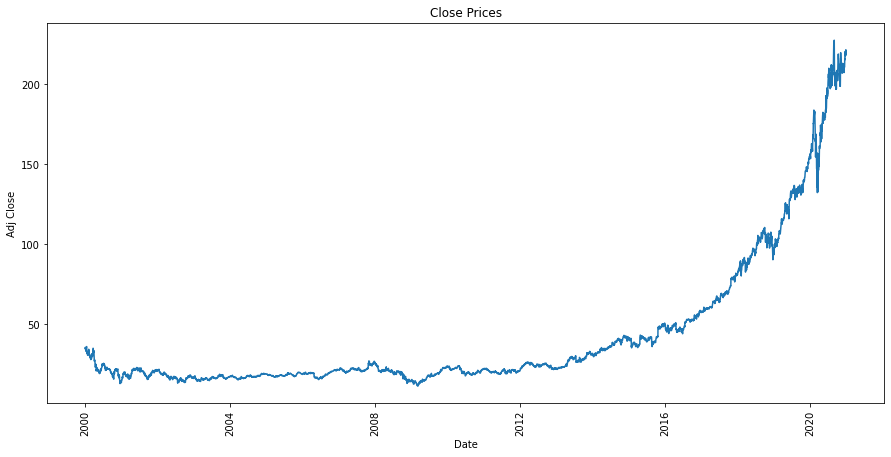

In [ ]:
dateNew = dateConvert(trainingData['Date'].reset_index(drop = True))
actualClose = trainingData[target].reset_index(drop = True)
actualClose = actualClose['Adj Close']
plotData = pd.DataFrame({'Date':dateNew, 'Adj Close':actualClose})
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(15,7))
sns.lineplot(x="Date", y="Adj Close", data = plotData).set(title="Close Prices")
sns.set_theme(style="darkgrid")
plt.xticks(rotation = 'vertical')
#plt.legend()
plt.show()

Plot of Difference Close Prices

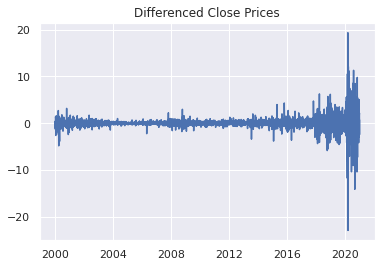

In [ ]:
actualClose = trainingDataVars[target].reset_index(drop = True)
actualClose = actualClose['Adj Close']
plotData = pd.DataFrame({'Date':dateNew, 'Adj Close':actualClose})
import seaborn as sns
import matplotlib.pyplot as plt
#fig, axes = plt.subplots(figsize=(15,7))
sns.lineplot(x="Date", y="Adj Close", data = plotData).set(xlabel="",
                      ylabel="",title="Differenced Close Prices")
sns.set_theme(style="darkgrid")
#plt.xticks(rotation = 'vertical')
#plt.legend()
plt.show()

Standardizing the features in the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
# train the normalization
scaler = StandardScaler()
scaler = scaler.fit(trainingDataVars)
# normalize the dataset and print
stdTrainData = scaler.transform(trainingDataVars)
stdTestData = scaler.transform(testingDataVars)

Plot of Standardized and Differenced Close Prices

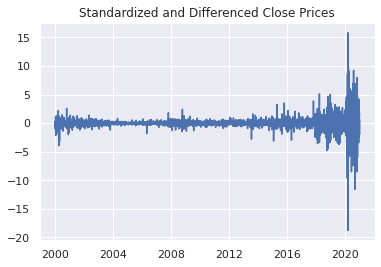

In [ ]:
#actualClose = stdTrainData[target].reset_index(drop = True)
#actualClose = actualClose['Adj Close']
plotData = pd.DataFrame({'Date':dateNew, 'Adj Close':stdTrainData[:,0]})
import seaborn as sns
sns.lineplot(x="Date", y="Adj Close", data = plotData).set(xlabel="",
                      ylabel="",title="Standardized and Differenced Close Prices")
sns.set_theme(style="darkgrid")


Data Conversion for LSTM modelling

In [ ]:
def dataConversion(data, target, numSteps):
    X, Y = list(), list()
    for i in range(len(data)):
        endIndx = i + numSteps
        if endIndx >= len(data):
            break
        dataX = data[i:endIndx]
        dataY = target[endIndx]
        X.append(dataX)
        Y.append(dataY)
    return np.asarray(X).astype(np.float32), np.asarray(Y).astype(np.float32)

dataXTrain,dataYTrain = dataConversion(stdTrainData, stdTrainData[:,0], numStepsDays)
dataXTest,dataYTest = dataConversion(stdTestData, stdTestData[:,0], numStepsDays)
#dataXTrain,dataYTrain = dataConversion(stdTrainData, trainingData[target], numStepsDays)
#dataXTest,dataYTest = dataConversion(stdTestData, testingData[target], numStepsDays)
#dataXTest2,dataYTest2 = dataConversion(testingData, target, numStepsDays)
#dataXTrain2.shape, dataYTrain2.shape
print(dataXTrain.shape,dataYTrain.shape,dataXTest.shape,dataYTest.shape)
print(trainingData.shape,testingData.shape)


(5273, 10, 5) (5273,) (409, 10, 5) (409,)
(5283, 7) (419, 7)


Function to define LSTM model structure

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
def createModelLSTM(batchSize, neurons1, neurons2): #, dropout):
  model = Sequential()
  model.add(LSTM(neurons1, input_shape=(numStepsDays, len(features)), return_sequences=True))
  model.add(LSTM(neurons2, activation="relu", return_sequences=False))
  #model.add(Dropout(dropout))
  model.add(Dense(1, activation="linear"))
  model.compile(loss='mean_squared_error', optimizer='adam')
  print(model.summary())
  #history = model.fit(trainX, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False)
  return model
 

Code for Time Series Validation and tuning of the model parameters

In [ ]:
import time
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

tscv = TimeSeriesSplit(n_splits=4)
batchSize = [32]
epochs = [x for x in range(2,15)]#
neurons1 = [7]
neurons2 = [6]
dropout = [0.2]
#numFeatures = [len(features)] batchSize, numEpoch, neurons1, neurons2, dropout
#timeSteps = [numStepsDays]
model = KerasRegressor(build_fn = createModelLSTM, verbose=1)
paramGrid = dict(batchSize=batchSize, epochs = epochs, 
                 neurons1 = neurons1, neurons2 = neurons2)#, dropout=dropout)
                 #timeSteps = timeSteps,numFeatures = numFeatures, 
grid = GridSearchCV(estimator = model, param_grid=paramGrid, n_jobs=-1, 
                    cv= tscv,return_train_score=True)  
start_time = time.time()
gridResult = grid.fit(dataXTrain, dataYTrain)
print("Executed in : ", (time.time() - start_time))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 7)             364       
                                                                 
 lstm_11 (LSTM)              (None, 6)                 336       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 707
Trainable params: 707
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/11
165/165 [==============================] - 4s 8ms/step - loss: 1.0014
Epoch 2/11
165/165 [==============================] - 1s 8ms/step - loss: 1.0002
Epoch 3/11
165/165 [==============================] - 1s 8ms/step - loss: 0.9993
Epoch 4/11
165/165 [==============================] - 1s 8ms/step - loss

In [ ]:
# summarize results
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score'] 
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#model.fit(X, y, epochs= numEpoch, batch_size= batchSize, verbose=1)

Best: -1.198199 using {'batchSize': 32, 'epochs': 11, 'neurons1': 7, 'neurons2': 6}
-1.203053 (1.874861) with: {'batchSize': 32, 'epochs': 2, 'neurons1': 7, 'neurons2': 6}
-1.201527 (1.872898) with: {'batchSize': 32, 'epochs': 3, 'neurons1': 7, 'neurons2': 6}
-1.204579 (1.878086) with: {'batchSize': 32, 'epochs': 4, 'neurons1': 7, 'neurons2': 6}
-1.199809 (1.869777) with: {'batchSize': 32, 'epochs': 5, 'neurons1': 7, 'neurons2': 6}
-1.204896 (1.878303) with: {'batchSize': 32, 'epochs': 6, 'neurons1': 7, 'neurons2': 6}
-1.222638 (1.909022) with: {'batchSize': 32, 'epochs': 7, 'neurons1': 7, 'neurons2': 6}
-1.204408 (1.878026) with: {'batchSize': 32, 'epochs': 8, 'neurons1': 7, 'neurons2': 6}
-1.200701 (1.871200) with: {'batchSize': 32, 'epochs': 9, 'neurons1': 7, 'neurons2': 6}
-1.221210 (1.906577) with: {'batchSize': 32, 'epochs': 10, 'neurons1': 7, 'neurons2': 6}
-1.198199 (1.866878) with: {'batchSize': 32, 'epochs': 11, 'neurons1': 7, 'neurons2': 6}
-1.215113 (1.895016) with: {'batch

In [ ]:
gridResult.param_grid['epochs'],abs(gridResult.cv_results_['mean_train_score']),abs(gridResult.cv_results_['mean_test_score'])

([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 array([0.14552156, 0.14555513, 0.14537737, 0.14464214, 0.14472714,
        0.1444668 , 0.14437945, 0.14481736, 0.14483806, 0.14426178,
        0.14342529, 0.14344215, 0.14369104]),
 array([1.20305332, 1.20152707, 1.20457898, 1.19980887, 1.2048957 ,
        1.22263839, 1.20440837, 1.2007013 , 1.22121007, 1.19819928,
        1.21511339, 1.20128369, 1.20901644]))

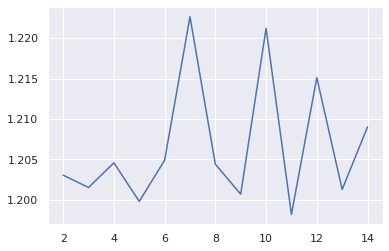

In [ ]:
import seaborn as sns
#sns.lineplot(x=gridResult.param_grid['epochs'], y=abs(gridResult.cv_results_['mean_train_score']))
sns.lineplot(x=gridResult.param_grid['epochs'], y= abs(gridResult.cv_results_['mean_test_score']))

Fitting the model with optimal hyperparameters

In [ ]:
import time
start_time = time.time()
lstm_model = createModelLSTM(32,7, 6)
lstm_model.fit(dataXTrain,dataYTrain,epochs=11)
print("Executed in : ", (time.time() - start_time))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 7)             364       
                                                                 
 lstm_13 (LSTM)              (None, 6)                 336       
                                                                 
 dense_6 (Dense)             (None, 1)                 7         
                                                                 
Total params: 707
Trainable params: 707
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/11
165/165 [==============================] - 4s 8ms/step - loss: 1.0011
Epoch 2/11
165/165 [==============================] - 1s 8ms/step - loss: 0.9989
Epoch 3/11
165/165 [==============================] - 1s 8ms/step - loss: 0.9966
Epoch 4/11
165/165 [==============================] - 3s 16ms/step - los

Predicting values on test dataset

In [ ]:
forecast = lstm_model.predict(dataXTest)
forecastDummy = np.repeat(forecast,len(features), axis = -1)
predForecasts = scaler.inverse_transform(forecastDummy)[:,0]

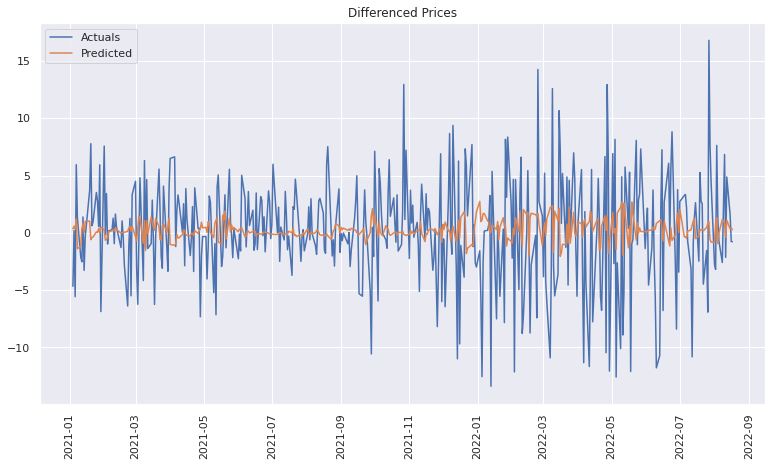

RMSE :  4.739885736162137
MSE :  22.466516791873282
MAPE :  2617763697672.9966
R2 Score :  -0.019864560070693704


4.739885736162137

In [ ]:
dateNew = dateConvert(testingData['Date'][numStepsDays:].reset_index(drop = True))
actualDiff = testingDataVars[target].reset_index(drop = True)
actualDiff = actualDiff['Adj Close'][numStepsDays:]
plotData = pd.DataFrame({'Date':dateNew, 'Adj Close':actualDiff})
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(13,7))

sns.lineplot(x="Date", y="Adj Close", data = plotData,label = "Actuals").set(xlabel="",
                      ylabel="",title="Differenced Prices")
plotData = pd.DataFrame({'Date':dateNew, 'Adj Close':forecast[:,0]})
sns.lineplot(x="Date", y="Adj Close", data = plotData,label = "Predicted").set(xlabel="",
                      ylabel="",title="Differenced Prices")
sns.set_theme(style="darkgrid")
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
print("RMSE : ", mean_squared_error(actualDiff, forecast[:,0], squared=False))
print("MSE : ", mean_squared_error(actualDiff, forecast[:,0]))
print("MAPE : ", mean_absolute_percentage_error(actualDiff, forecast[:,0]))
print("R2 Score : ", r2_score(actualDiff, forecast[:,0]))
from math import sqrt 
sqrt(mean_squared_error(actualDiff, forecast[:,0]))

Converting the predicted values to get Actual Prices

In [ ]:
lastTargetTrain = stockData[target].values[[testStartIndx-1]][0][0]
predInverted = list()
actualTargets = testingData[target][numStepsDays:].values
predInverted.append(inverseDifference(lastTargetTrain, predForecasts[0]))
for i in range(1, len(predForecasts)):
  newPred = inverseDifference(actualTargets[i-1][0], predForecasts[i])
  predInverted.append(newPred)

In [ ]:
forcastDates = testingData["Date"][numStepsDays:]
testActual = pd.concat([stockData['Date'][numStepsDays:], stockData[target][numStepsDays:]], axis=1).reset_index()
testPred = pd.DataFrame({'Date':np.array(forcastDates), 'PredictedTarget':predInverted})
from datetime import datetime
def dateConvert(data):
  dates = []
  for i in range(len(data)):
    dates.append(datetime.strptime(data[i], '%Y-%m-%d').date())
  return(dates)
dateNew = dateConvert(testPred['Date'])
testPred['Date'] = dateNew
dateNew = dateConvert(testActual['Date'])
testActual['Date'] = dateNew

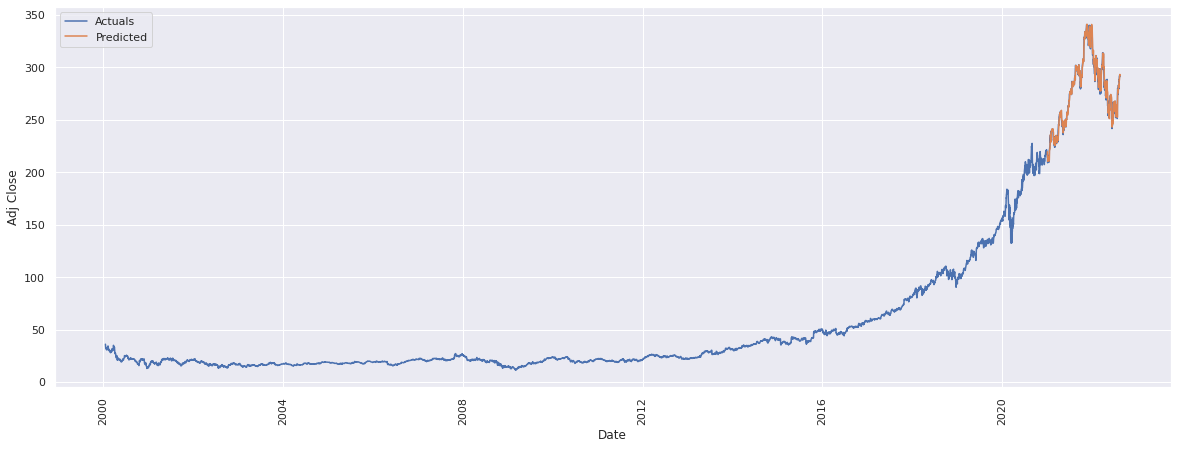

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x="Date", y="Adj Close", data = testActual,label = "Actuals")
sns.lineplot(x="Date", y= "PredictedTarget", data = testPred,label = "Predicted")
sns.set_theme(style="darkgrid")
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()


Plot of Actuals vs Predicted on the test dataset

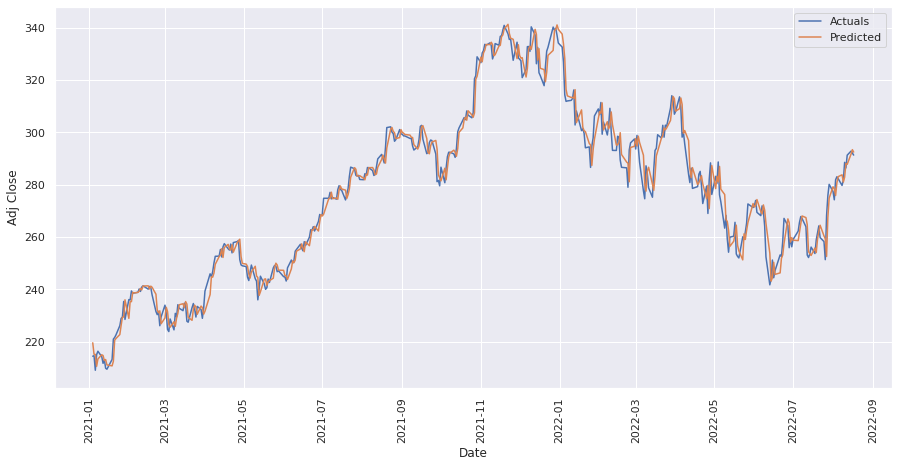

In [ ]:
testActual = testActual.iloc[np.where(testActual['Date']== dateConvert([testStartDate])[0])[0][0]:]
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(15,7))
sns.lineplot(x="Date", y="Adj Close", data = testActual,label = "Actuals")
sns.lineplot(x="Date", y= "PredictedTarget", data = testPred,label = "Predicted")
sns.set_theme(style="darkgrid")
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()

Model Evaluation Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
print("RMSE : ", mean_squared_error(testActual['Adj Close'], testPred['PredictedTarget'], squared=False))
print("MSE : ", mean_squared_error(testActual['Adj Close'], testPred['PredictedTarget']))
print("MAPE : ", mean_absolute_percentage_error(testActual['Adj Close'], testPred['PredictedTarget']))
print("R2 Score : ", r2_score(testActual['Adj Close'], testPred['PredictedTarget']))
from math import sqrt 
sqrt(mean_squared_error(testActual['Adj Close'], testPred['PredictedTarget']))

RMSE :  4.772196240280076
MSE :  22.773856955743295
MAPE :  0.013152103872143682
R2 Score :  0.9776063242692308


4.772196240280076

Saving the model file for future use

In [ ]:
filename = "/drive/My Drive/Colab Notebooks/%sModel" % stock
lstm_model.save(filename)